In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

def eval_retrieval(queries, k=5):
    rows = []
    for q in queries:
        predicted = retrieve(q["query"], k)
        ground = set(q["ground_truth"])
        retrieved = set(predicted)

        # Binary relevansi untuk metrik klasik
        y_true = [1 if i in ground else 0 for i in predicted]
        y_pred = [1] * len(predicted)  # semua prediksi dianggap positif

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        hit = int(bool(ground & retrieved))  # at least 1 match

        rows.append({
            "query_id": q["id"],
            "query": q["query"],
            "hit": hit,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "top_k": predicted,
            "ground_truth": list(ground)
        })

    df = pd.DataFrame(rows)
    df.to_csv("/content/drive/MyDrive/cbr_banking/data/eval/retrieval_metrics.csv", index=False)
    return df


In [ ]:
from sklearn.metrics import classification_report

def eval_prediction(preds, ground_truths):
    # asumsi preds & truths adalah list string: ["bebas", "bersalah", ...]
    y_true = ground_truths
    y_pred = preds
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    pd.DataFrame(report).T.to_csv("/content/drive/MyDrive/cbr_banking/data/eval/prediction_metrics.csv")


In [ ]:
with open("/content/drive/MyDrive/cbr_banking/data/eval/queries.json", "r") as f:
    queries_raw = json.load(f)

# Tambahkan ID otomatis
queries = [{"id": i+1, **q} for i, q in enumerate(queries_raw)]

df_eval = eval_retrieval(queries, k=10)
df_eval.head()


,query_id,query,hit,precision,recall,f1,top_k,ground_truth
0,1,penipuan dana nasabah oleh teller bank,0,0.0,0.0,0.0,"[100, 104, 150, 144, 141, 147, 55, 37, 92, 70]",[5]
1,2,penggelapan anggaran kredit koperasi,0,0.0,0.0,0.0,"[100, 131, 138, 123, 29, 48, 104, 79, 70, 109]",[12]
2,3,korupsi direktur bank swasta,0,0.0,0.0,0.0,"[117, 145, 142, 110, 128, 148, 56, 38, 20, 71]",[3]
3,4,pemalsuan dokumen rekening,0,0.0,0.0,0.0,"[42, 121, 79, 100, 104, 34, 102, 73, 6, 51]",[8]


In [ ]:
!pip install transformers -q
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# === Load data
df = pd.read_csv("/content/drive/MyDrive/cbr_banking/data/processed/cases.csv")

# === Load IndoBERT tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

# === Ambil kolom ringkasan_fakta sebagai representasi dokumen
corpus = df['ringkasan_fakta'].fillna("").tolist()

# === Fungsi embed teks pakai mean pooling
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state
    mask = inputs['attention_mask'].unsqueeze(-1).expand(last_hidden.size()).float()
    masked_output = last_hidden * mask
    summed = torch.sum(masked_output, 1)
    counts = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / counts
    return mean_pooled.squeeze().numpy()

# === Embed semua dokumen
doc_embeddings = np.array([get_embedding(t) for t in corpus])
print("✅ Selesai embed dokumen:", doc_embeddings.shape)


✅ Selesai embed dokumen: (150, 768)


In [ ]:
def retrieve(query: str, k: int = 5):
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_embeddings)[0]
    top_k_idx = sims.argsort()[-k:][::-1]
    return (top_k_idx + 1).tolist()  # +1 karena case_id mulai dari 1


In [ ]:
import json

with open("/content/drive/MyDrive/cbr_banking/data/eval/queries.json") as f:
    queries_raw = json.load(f)

queries = [{"id": i+1, **q} for i, q in enumerate(queries_raw)]

df_eval = eval_retrieval(queries, k=100)
df_eval.head()


,query_id,query,hit,precision,recall,f1,top_k,ground_truth
0,1,penipuan dana nasabah oleh teller bank,1,0.006667,1.0,0.013245,"[103, 123, 48, 63, 2, 35, 50, 9, 29, 6, 122, 6...",[5]
1,2,penggelapan anggaran kredit koperasi,1,0.006667,1.0,0.013245,"[103, 63, 2, 48, 123, 136, 126, 135, 49, 122, ...",[12]
2,3,korupsi direktur bank swasta,1,0.006667,1.0,0.013245,"[48, 123, 120, 81, 138, 78, 69, 86, 87, 33, 14...",[3]
3,4,pemalsuan dokumen rekening,1,0.006667,1.0,0.013245,"[147, 148, 146, 145, 143, 144, 129, 141, 142, ...",[8]


In [ ]:
# --- Import ---
import pandas as pd
import numpy as np
import json
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

# --- Load dataset dan queries ---
df = pd.read_csv("/content/drive/MyDrive/cbr_banking/data/processed/cases.csv")
with open("/content/drive/MyDrive/cbr_banking/data/eval/queries.json", "r") as f:
    queries = json.load(f)

queries = [{"id": i+1, **q} for i, q in enumerate(queries)]

# --- IndoBERT Setup ---
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

def bert_embed(text: str) -> np.ndarray:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# --- Load IndoBERT Embedding ---
bert_matrix = np.load("/content/drive/MyDrive/cbr_banking/bert_embeddings_textfull.npy")

def retrieve_bert(query: str, k: int = 100):
    q_vec = bert_embed(query).reshape(1, -1)
    sims = cosine_similarity(q_vec, bert_matrix).flatten()
    top_k = np.argsort(sims)[-k:][::-1]
    return df.iloc[top_k]["case_id"].tolist()

# --- TF-IDF Setup ---
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(df["text_full"].fillna(""))

def retrieve_tfidf(query: str, k: int = 100):
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, tfidf_matrix).flatten()
    top_k = np.argsort(sims)[-k:][::-1]
    return df.iloc[top_k]["case_id"].tolist()

# --- SVM Setup ---
svm = SVC(probability=True, kernel='linear')
svm_y = df["case_id"]
svm.fit(tfidf_matrix, svm_y)

def retrieve_svm(query: str, k: int = 100):
    q_vec = vectorizer.transform([query])
    probs = svm.predict_proba(q_vec)[0]
    top_k_idx = np.argsort(probs)[-k:][::-1]
    return svm.classes_[top_k_idx].tolist()

# --- Evaluasi Fungsi ---
def evaluate_model(name, retrieve_fn, k=100):
    rows = []
    for q in queries:
        gt = set(q["ground_truth"])
        top_k = retrieve_fn(q["query"], k)
        hit = int(any(c in gt for c in top_k))
        precision = sum(1 for c in top_k if c in gt) / k
        recall = sum(1 for c in top_k if c in gt) / len(gt)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        rows.append({
            "query_id": q["id"],
            "query": q["query"],
            "hit": hit,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "model": name,
            "top_k": top_k,
            "ground_truth": list(gt)
        })
    return pd.DataFrame(rows)

# --- Jalankan Evaluasi Semua Model ---
df_bert = evaluate_model("IndoBERT", retrieve_bert)
df_tfidf = evaluate_model("TF-IDF", retrieve_tfidf)
df_svm = evaluate_model("SVM", retrieve_svm)

# --- Gabung dan Simpan ---
df_all = pd.concat([df_bert, df_tfidf, df_svm])
df_all.to_csv("/content/drive/MyDrive/cbr_banking/data/eval/retrieval_metrics.csv", index=False)
print("✅ Evaluasi berhasil disimpan ke retrieval_metrics.csv")

# --- Tampilkan ringkasan skor rata-rata ---
df_all.groupby("model")[["hit", "precision", "recall", "f1"]].mean()


✅ Evaluasi berhasil disimpan ke retrieval_metrics.csv


,hit,precision,recall,f1
model,,,,
IndoBERT,0.50,0.0050,0.50,0.009901
SVM,0.75,0.0075,0.75,0.014851
TF-IDF,1.00,0.0100,1.00,0.019802


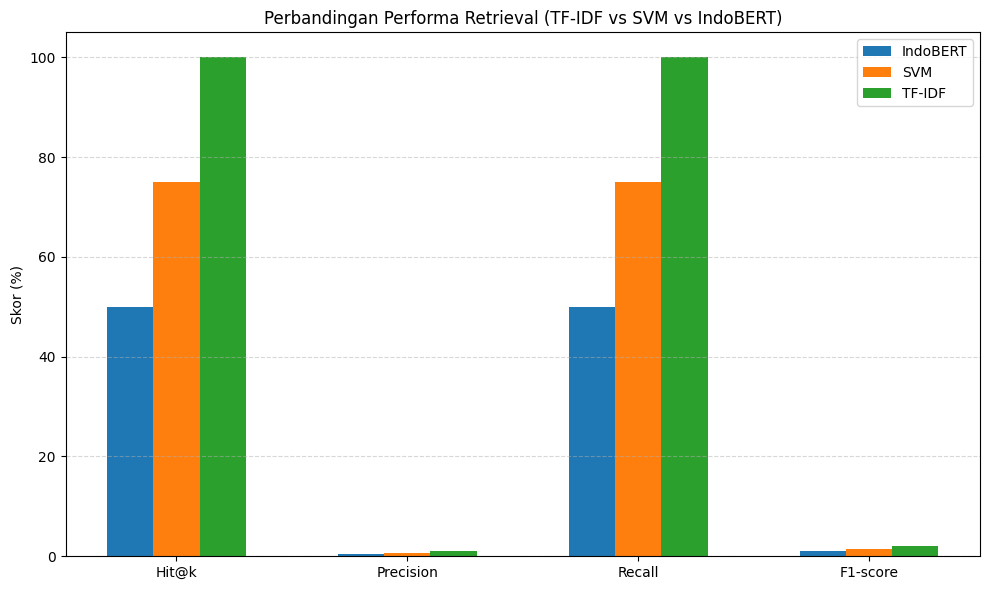

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load hasil evaluasi semua model
df_all = pd.read_csv("/content/drive/MyDrive/cbr_banking/data/eval/retrieval_metrics.csv")

# Hitung mean per metric per model
agg = df_all.groupby("model")[["hit", "precision", "recall", "f1"]].mean().reset_index()

# Konversi hit ke persen
agg["hit"] *= 100
agg["precision"] *= 100
agg["recall"] *= 100
agg["f1"] *= 100

# Plot
metrics = ["hit", "precision", "recall", "f1"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # TF-IDF, SVM, IndoBERT

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = range(len(metrics))

for i, model in enumerate(agg["model"]):
    values = agg.loc[agg["model"] == model, metrics].values.flatten()
    ax.bar([x + i * bar_width for x in index], values, width=bar_width, label=model, color=colors[i])

# Format
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(["Hit@k", "Precision", "Recall", "F1-score"])
ax.set_ylabel("Skor (%)")
ax.set_title("Perbandingan Performa Retrieval (TF-IDF vs SVM vs IndoBERT)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("/content/drive/MyDrive/cbr_banking/data/eval/retrieval_bar_chart.png")

<Figure size 640x480 with 0 Axes>